In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

from processing_functions import *

In [2]:
df = pd.read_csv('data/input_file.csv')
nan_percentage(df) 

NaN % Unnamed: 0: 0.00%
NaN % iid: 0.00%
NaN % id: 0.01%
NaN % wave: 0.00%
NaN % partner: 0.00%
NaN % pid: 0.12%
NaN % match: 0.00%
NaN % int_corr: 1.89%
NaN % age_o: 1.24%
NaN % pf_o_att: 1.06%
NaN % pf_o_sin: 1.06%
NaN % pf_o_int: 1.06%
NaN % pf_o_fun: 1.17%
NaN % pf_o_amb: 1.28%
NaN % pf_o_sha: 1.54%
NaN % dec_o: 0.00%
NaN % attr_o: 2.53%
NaN % sinc_o: 3.43%
NaN % intel_o: 3.65%
NaN % fun_o: 4.30%
NaN % amb_o: 8.62%
NaN % shar_o: 12.84%
NaN % like_o: 2.98%
NaN % prob_o: 3.80%
NaN % age: 1.13%
NaN % imprelig: 0.94%
NaN % goal: 0.94%
NaN % date: 1.16%
NaN % go_out: 0.94%
NaN % sports: 0.94%
NaN % tvsports: 0.94%
NaN % exercise: 0.94%
NaN % dining: 0.94%
NaN % museums: 0.94%
NaN % art: 0.94%
NaN % hiking: 0.94%
NaN % gaming: 0.94%
NaN % clubbing: 0.94%
NaN % reading: 0.94%
NaN % tv: 0.94%
NaN % theater: 0.94%
NaN % movies: 0.94%
NaN % concerts: 0.94%
NaN % music: 0.94%
NaN % shopping: 0.94%
NaN % yoga: 0.94%
NaN % exphappy: 1.21%
NaN % expnum: 78.52%
NaN % attr_important: 0.00%
NaN % s

There is a lot of data missing for how people think others perceive them, and what attributes they think the rest of their sex prefer. 

Since I am also going to be working with no gender, I will drop any column related to the binary separation of gender.

The attribute that overall has the most amount of missing data is 'shared interests'. I was hoping to use this attribute as a reliable feature to find partners, but based on the findings made in the EDA it is the feature that is the least important. 

In [3]:
def drop_columns(df, suffix):
    cols = [col for col in df.columns if any(col.endswith(s) for s in suffix)]
    
    df = df.drop(columns=cols, errors='ignore')
    
    return df
    

suffix= ['_fellow_want', 'perceived', '_o_want', '_diff']
df = drop_columns(df, suffix)
df = df.drop(columns=['Unnamed: 0'])

Since there are too many people and waves in this experiment, I am going to opt to drop the rows that have nan values so that it is easier to work with when it comes to training the dataset (especially with Random Forest). 

In [4]:
df.head()

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
2,1,1.0,1,3,13.0,1,0.16,22.0,19.0,18.0,...,4,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0


In [5]:
df = df.dropna()
df

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,1,1.0,1,6,16.0,0,0.25,25.0,50.0,0.0,...,4,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,131,10.0,5,1,112.0,0,0.35,20.0,15.0,15.0,...,3,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1837,131,10.0,5,2,113.0,0,0.45,21.0,15.0,15.0,...,2,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1838,131,10.0,5,3,114.0,0,0.13,20.0,20.0,20.0,...,3,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1840,131,10.0,5,5,116.0,0,0.54,21.0,15.0,15.0,...,2,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0


In [6]:
# Dropping identifier columns and irrelevant features for prediction
df = df.drop(columns=['iid', 'id', 'pid', 'partner', 'wave'], axis=1)

In [7]:
df

,match,int_corr,age_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,0,0.14,27.0,35.0,20.0,20.0,20.0,0.0,5.0,0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,0,0.54,22.0,60.0,0.0,0.0,40.0,0.0,0.0,0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,0.61,23.0,30.0,5.0,15.0,40.0,5.0,5.0,1,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,0.21,24.0,30.0,10.0,20.0,10.0,10.0,20.0,1,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,0,0.25,25.0,50.0,0.0,30.0,10.0,0.0,10.0,1,...,4,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,0,0.35,20.0,15.0,15.0,20.0,25.0,10.0,15.0,0,...,3,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1837,0,0.45,21.0,15.0,15.0,25.0,25.0,15.0,5.0,0,...,2,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1838,0,0.13,20.0,20.0,20.0,20.0,20.0,10.0,10.0,0,...,3,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1840,0,0.54,21.0,15.0,15.0,25.0,25.0,20.0,0.0,0,...,2,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0


In [24]:
X = df.drop(['match', 'dec', 'dec_o'], axis=1)
y = df['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [9]:
# Start by modelling a LightGBM and Random Forest model 
# Will do comparison of both and decide based on 
# maybe can try to use LightGBM but using 'random forest' as the boosting_type(?)
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    min_data_in_leaf=30,
    min_gain_to_split=0.01,
    max_depth=10,
    num_leaves=31,
    n_estimators=100,
    learning_rate=0.1,
    verbose=-1 
)
rf_model = RandomForestClassifier(random_state=42)

lgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
rf_accuracy = cross_val_score(rf_model, X_train, y_train, cv=5)
lgb_accuracy = cross_val_score(lgb_model, X_train, y_train, cv=5)

print("Random Forest Accuracy: ", rf_accuracy.mean())
print("LightGBM Accuracy: ", lgb_accuracy.mean())

Random Forest Accuracy:  0.8382039800995024
LightGBM Accuracy:  0.8521791044776119


In [11]:
# Comparison between models with classification_report
# Make prediction on the testing data
y_pred_rf = rf_model.predict(X_test)
y_pred_lgm = lgb_model.predict(X_test)

# Classification Report
print("random forest classifier\n", classification_report(y_pred_rf, y_test))
print("LightGBM\n", classification_report(y_pred_lgm, y_test))

random forest classifier
               precision    recall  f1-score   support

           0       0.97      0.90      0.93       224
           1       0.47      0.74      0.57        27

    accuracy                           0.88       251
   macro avg       0.72      0.82      0.75       251
weighted avg       0.91      0.88      0.89       251

LightGBM
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       213
           1       0.58      0.66      0.62        38

    accuracy                           0.88       251
   macro avg       0.76      0.79      0.77       251
weighted avg       0.88      0.88      0.88       251



In [12]:
df['match'].value_counts(normalize=True)

0    0.800319
1    0.199681
Name: match, dtype: float64

After looking at the accuracy and the other metrics we can see that, same as had previously measured in the EDA, this is a very unbalanced dataset. Almost 80% of the values belong to 0, while only 20% is part of the positive results.

There is a much higher number of 0s (no matches) than 1s (matches), there this makes the precision, accuracy and recall of the matches much more lower than the no matches.

We need to find a weight balance in order to work with it and in return choose the most appropriate model to work with.
References found in: [https://stackoverflow.com/questions/51190809/high-auc-but-bad-predictions-with-imbalanced-data]

We might also want to look into the performance of a =XGBoost= model since it performs better for unbalanced data. 
The boosting algorithm iteratively learns from the mistakes of the previous tree. So if a tree fails to predict a class (most likely the imbalanced class), the proceeding tree will give more weightage to this sample.

In [42]:
training_cols = X_train.columns

def pr_threshold(model, X_val, y_val):
    # Predict probabilities for the positive class
    proba = model.predict_proba(X_val)[:, 1]

    # Calculate precision, recall, and thresholds using the predicted probabilities
    precision, recall, thresholds = precision_recall_curve(y_val, proba)

    # Calculate the F-score for each threshold
    fscore = (2 * precision * recall) / (precision + recall + 1e-12)  # Add a tiny constant to avoid division by zero

    # Find the index of the maximum F-score
    ix = np.argmax(fscore)

    # Return the threshold corresponding to the maximum F-score
    return thresholds[ix]

optimal_threshold = pr_threshold(rf_model, X_val, y_val)
print("Optimal threshold for maximum F1-score:", optimal_threshold)

print(f"Using threshold ~{optimal_threshold:.4f} for evaluation.")

Optimal threshold for maximum F1-score: 0.61
Using threshold ~0.6100 for evaluation.


In [66]:
final_predictions = (rf_model.predict_proba(X_val)[:, 1] >= optimal_threshold).astype(int)
# Generate and print the classification report with the optimal threshold
optimal_report = classification_report(y_val, final_predictions, zero_division=0)
#print(optimal_report)

probabilities = rf_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probabilities)
f1_scores = 2 * (precision * recall) / (precision + recall)

optimal_idx = np.argmax(f1_scores)
rf_optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold is: ", rf_optimal_threshold)

Optimal threshold is:  0.43


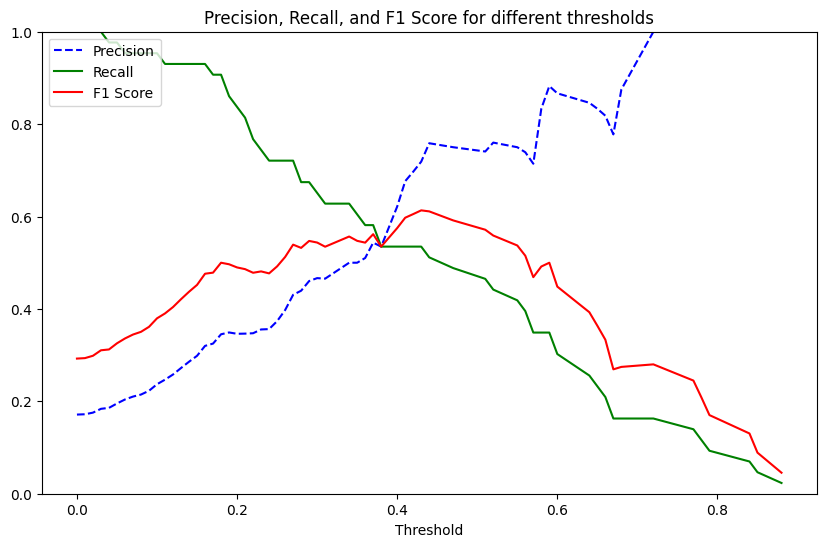

In [64]:
predictions = (probabilities >= optimal_threshold).astype(int)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'r-', label='F1 Score')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.title('Precision, Recall, and F1 Score for different thresholds')
plt.show()

In [67]:
final_predictions = (rf_model.predict_proba(X_test)[:, 1] >= rf_optimal_threshold).astype(int)
# Generate and print the classification report with the optimal threshold
optimal_report = classification_report(y_test, final_predictions, zero_division=0)
print(optimal_report)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       208
           1       0.72      0.53      0.61        43

    accuracy                           0.88       251
   macro avg       0.81      0.75      0.77       251
weighted avg       0.88      0.88      0.88       251



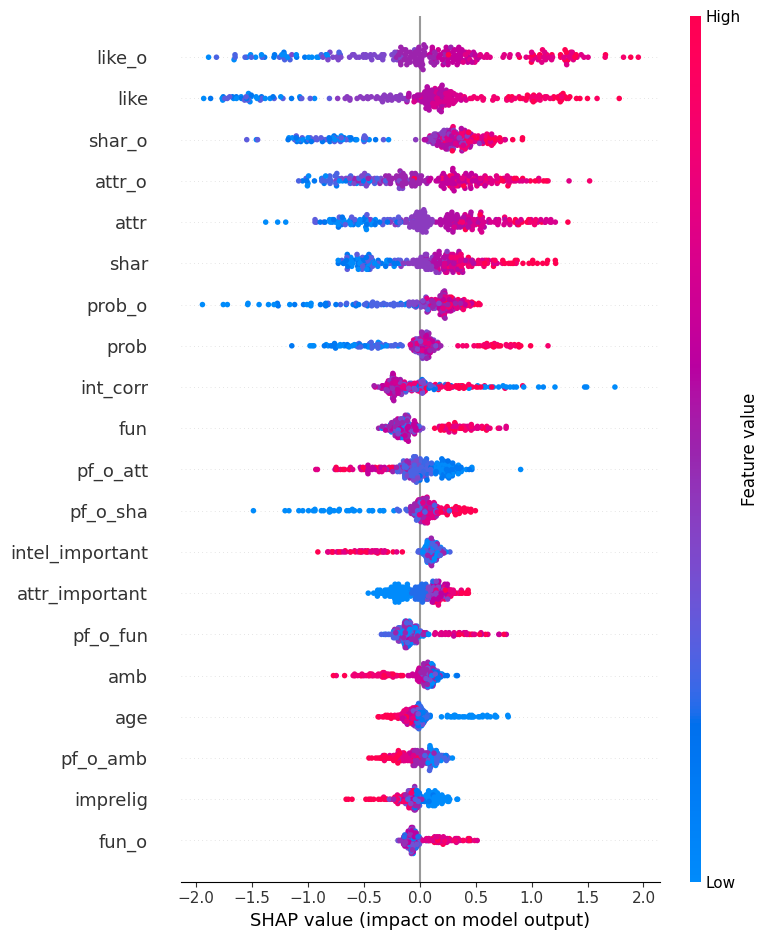

In [22]:
import shap

explainer = shap.TreeExplainer(lgb_model, X_train)
shap_values_lgm = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_lgm, X_test)

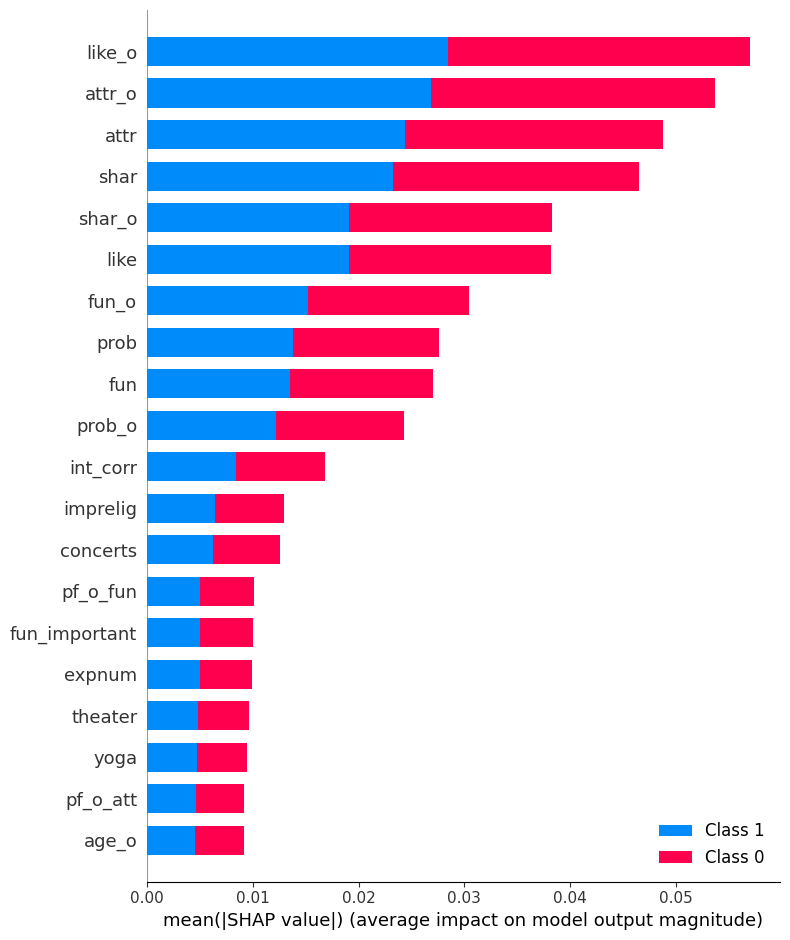

In [15]:
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)